**Computer Assignment 1 (Langevin sampling algorithm)**

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np

Plotting options (do not change)

In [4]:
plotting_range = np.array([[-4, 6], [-4, 6]])
nbins = 50
density = False

Specify mean and covariance

In [5]:
mean = torch.tensor([1., 1.])
cov = torch.tensor([[1., 0.9],
        [0.9, 1.]])
#TODO
M = np.linalg.inv(cov)

In [6]:
def score(x):
	return -M.dot(x - mean)

In [7]:
def langevin_dynamics(x0, T, mu):
	#TODO
	dim = len(x0)
	samples = torch.zeros((T + 1, dim))
	samples[0] = x0
	for i in range(T):
		samples[i+1] = samples[i] + mu * score(samples[i]) + np.sqrt(2*mu) * np.random.normal(0, 1, dim)
		
	return samples

Considered scenarios

In [8]:
Ts = [1_000, 10_000, 100_000]
mus = [0.001, 0.01, 0.15]

x0 = torch.tensor([0,0]) #TODO

Run sampling

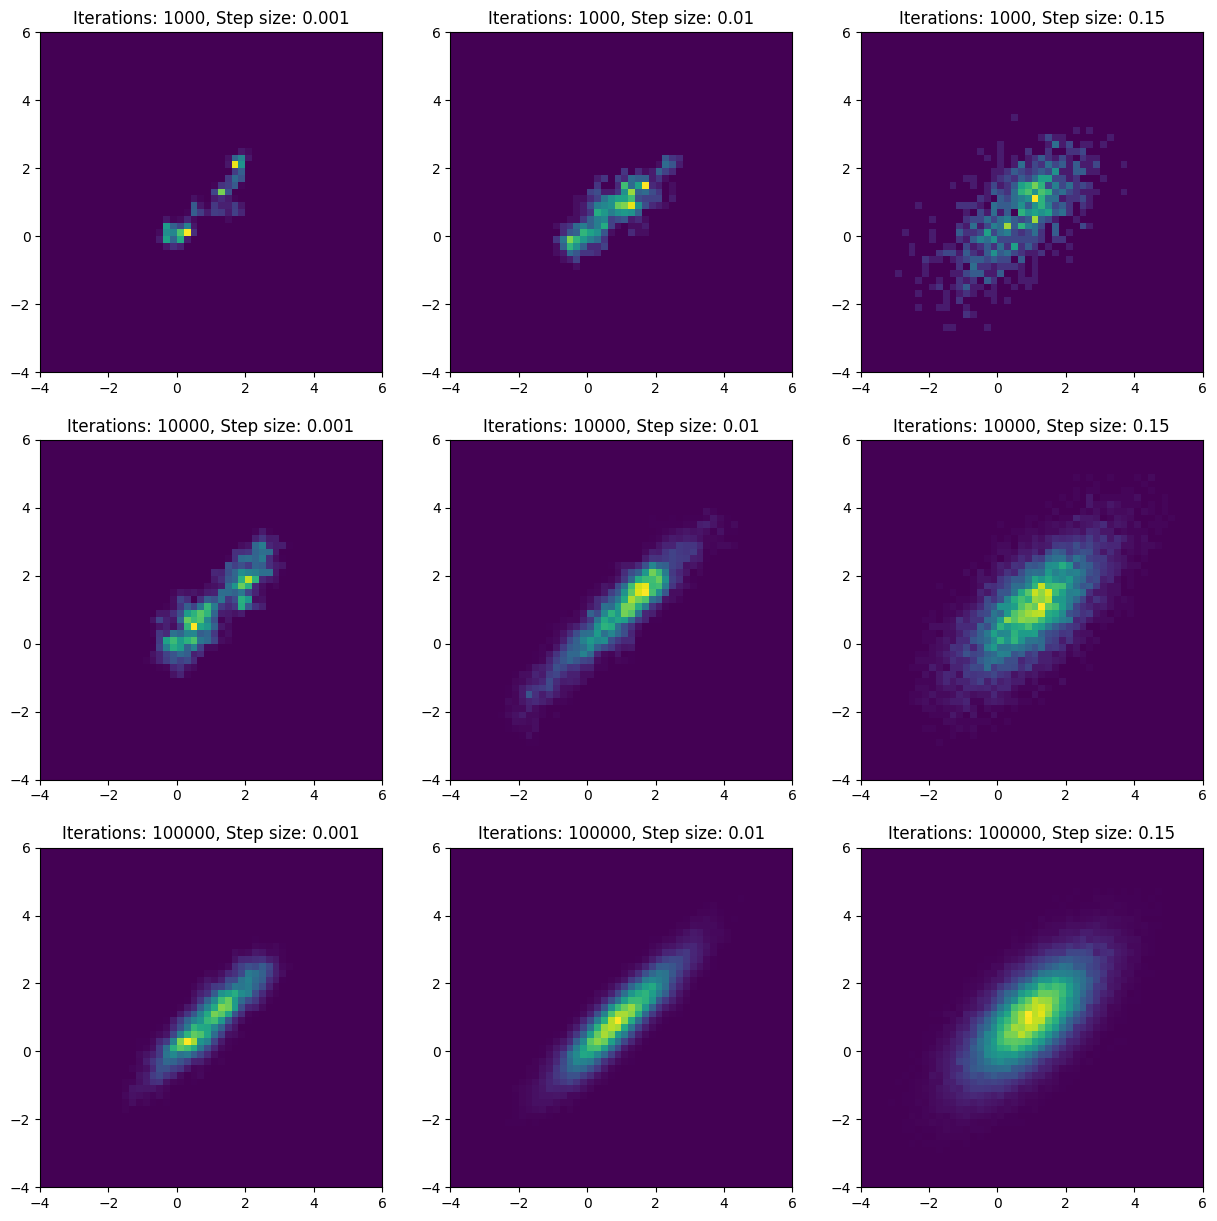

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
for i,T in enumerate(Ts):
    for j,mu in enumerate(mus):
        samples = langevin_dynamics(x0,T,mu)
        axes[i,j].hist2d(samples[:, 0], samples[:, 1], bins=nbins, range=plotting_range, density=False)
        axes[i,j].set_title(f'Iterations: {T}, Step size: {mu}')
plt.show()

Compare results to the target

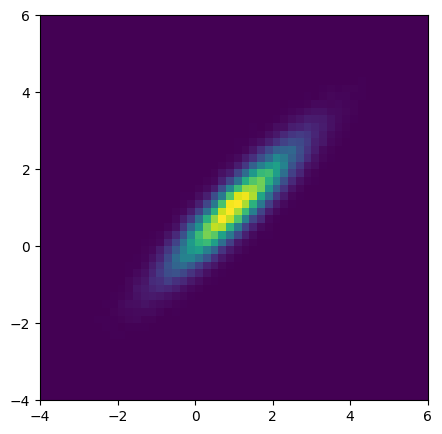

In [10]:
target = torch.distributions.multivariate_normal.MultivariateNormal(mean, cov)
target_samples = target.sample((Ts[2],))
plt.figure(figsize=(5, 5))
plt.hist2d(target_samples[:, 0], target_samples[:, 1], bins=nbins, range=plotting_range, density=False)
plt.show()

The best results were obtained by the combination of number of iterations 100000 and step size 0.01 and the closest result to the target this is because it's very close to the optimal combination and offers close to perfect balance to stability and accuracy. We can see that when we increase the step size we obtain highly noisy/divergent samples, sometimes invalid. On the other hand a step size too small improves stability but lacks exploration which leads to samples being very close to the high probability area. The perfect balance. at least from the plots, is found with a step size of 0.01.

**Computer Assignment 2 (GAN)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
batch_size = 128
latent_dim = 100
hidden_dim = 256
img_size = 28*28
epochs = 30
lr = 0.0002
beta1 = 0.5

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])  # Normalize to [-1, 1]
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True,transform=transform, download=True)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

#### Discriminator

In [5]:
class Discriminator(nn.Module):
	def __init__(self):
		super(Discriminator, self).__init__()
		self.model = nn.Sequential(
			nn.Linear(img_size, hidden_dim * 4),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Dropout(0.3),
			nn.Linear(hidden_dim * 4, hidden_dim * 2),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Dropout(0.3),
			nn.Linear(hidden_dim * 2, hidden_dim),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Dropout(0.3),
			nn.Linear(hidden_dim, 1),
			nn.Sigmoid()
		)

	def forward(self, img):
		img_flat = img.view(img.size(0), -1)
		validity = self.model(img_flat)
		return validity

#### Generator Network

In [ ]:
class Generator(nn.Module):
	def __init__(self):
		super(Generator, self).__init__()
		self.model = nn.Sequential(
			nn.Linear(latent_dim, hidden_dim),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(hidden_dim, hidden_dim * 2),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(hidden_dim * 2, hidden_dim * 4),
			nn.LeakyReLU(0.2, inplace=True),
			nn.Linear(hidden_dim * 4, img_size),
			nn.Tanh()  # Output in [-1, 1]
		)

	def forward(self, z):
		img = self.model(z)
		img = img.view(img.size(0), 1, 28, 28)
		return img


#### Training

In [8]:
g = Generator()
d = Discriminator()

loss = nn.BCELoss()

g_optim = optim.Adam(g.parameters(), lr=lr, betas=(beta1, 0.999))
d_optim = optim.Adam(d.parameters(), lr=lr, betas=(beta1, 0.999))

losses_G = []
losses_D = []

for epoch in range(epochs):
	g_losses = []
	d_losses = []
	
	for images, labels in dataloader:
		real_labels = torch.ones(images.size(0), 1)
		fake_labels = torch.zeros(images.size(0), 1)
		
		d_optim.zero_grad()
		real_out = d(images)
		d_real_loss = loss(real_out, real_labels)
		z = torch.randn(images.size(0), latent_dim)
		fake_out = d(g(z).detach())
		d_fake_loss = loss(fake_out, fake_labels)
		d_loss = (d_real_loss + d_fake_loss) / 2
		d_loss.backward()
		d_optim.step()
		
		g_optim.zero_grad()
		z = torch.randn(images.size(0), latent_dim)
		gen_imgs = g(z)
		validity = d(gen_imgs)
		g_loss = loss(validity, real_labels)
		g_loss.backward()
		g_optim.step()
		g_losses.append(g_loss.item())
		d_losses.append(d_loss.item())
		
	avg_g_loss = sum(g_losses) / len(g_losses)
	avg_d_loss = sum(d_losses) / len(d_losses)
	losses_G.append(avg_g_loss)
	losses_D.append(avg_d_loss)
	
	print(f"Epoch [{epoch+1}/{epochs}] - avg_d_loss: {avg_d_loss:.4f}, avg_g_loss: {avg_g_loss:.4f}")

Epoch [1/30] - avg_d_loss: 0.3905, avg_g_loss: 2.1103
Epoch [2/30] - avg_d_loss: 0.2728, avg_g_loss: 3.3966
Epoch [3/30] - avg_d_loss: 0.2700, avg_g_loss: 3.2176
Epoch [4/30] - avg_d_loss: 0.2840, avg_g_loss: 2.5668
Epoch [5/30] - avg_d_loss: 0.2404, avg_g_loss: 2.6328
Epoch [6/30] - avg_d_loss: 0.2809, avg_g_loss: 2.4191
Epoch [7/30] - avg_d_loss: 0.3131, avg_g_loss: 2.3036
Epoch [8/30] - avg_d_loss: 0.3360, avg_g_loss: 2.1283
Epoch [9/30] - avg_d_loss: 0.4038, avg_g_loss: 1.7818
Epoch [10/30] - avg_d_loss: 0.4343, avg_g_loss: 1.6082
Epoch [11/30] - avg_d_loss: 0.4565, avg_g_loss: 1.5053
Epoch [12/30] - avg_d_loss: 0.4629, avg_g_loss: 1.4960
Epoch [13/30] - avg_d_loss: 0.4811, avg_g_loss: 1.4069
Epoch [14/30] - avg_d_loss: 0.4857, avg_g_loss: 1.4053
Epoch [15/30] - avg_d_loss: 0.4978, avg_g_loss: 1.3605
Epoch [16/30] - avg_d_loss: 0.5102, avg_g_loss: 1.3078
Epoch [17/30] - avg_d_loss: 0.5158, avg_g_loss: 1.2899
Epoch [18/30] - avg_d_loss: 0.5243, avg_g_loss: 1.2469
Epoch [19/30] - avg

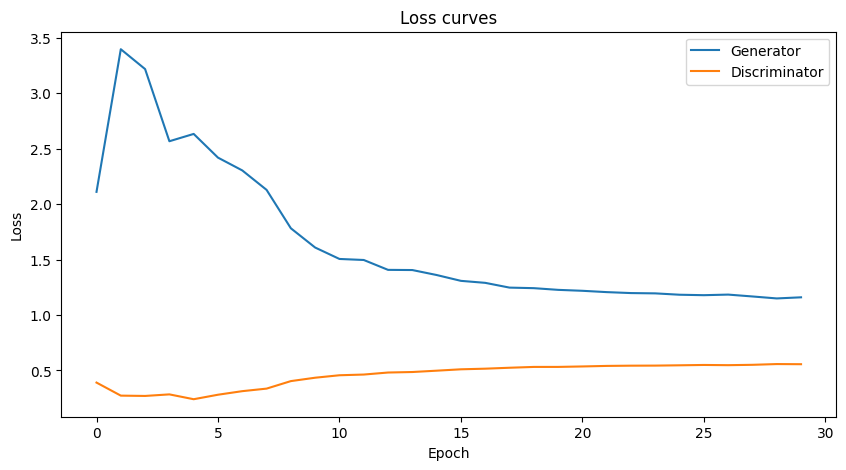

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(losses_G, label='Generator')
plt.plot(losses_D, label='Discriminator')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss curves')
plt.show()

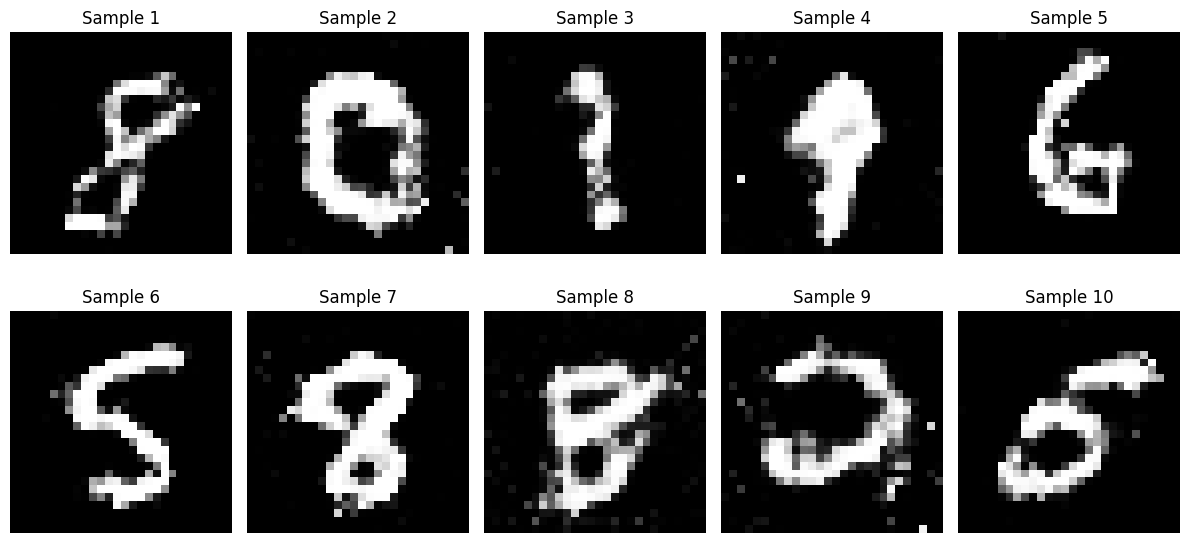

In [16]:
with torch.no_grad():
	z = torch.randn(10, latent_dim)
	gen_imgs = g(z).detach().cpu()
	gen_imgs = 0.5 * gen_imgs + 0.5
	plt.figure(figsize=(12, 6))
	for i in range(10):
		plt.subplot(2, 5, i+1)
		plt.imshow(gen_imgs[i].squeeze(), cmap='gray')
		plt.title(f"Sample {i+1}")
		plt.axis('off')
	plt.tight_layout()
	plt.savefig('final_gan_samples_with_titles.png')
	plt.show()

Overall the desired output was obtained. The generated images look very similar to the ones in the MNIST dataset but not perfect. The trained model is moderately complex, with layers up to 1024 nodes which allows for a highly capable neural network for the task which in turn gives fairly high accuracy on the final image generation. 